# Tree Search Analysis

Given the tree search for a single step, analyse it to have an idea of how it has been grown.

Some ideas:
- main variables that we have are: visit counts per node, total visit counts (= visit counts of the root node), number of visited children, depth of the node, depth of a branch (e.g. how in depth we explored an action).
- tree is asymmetric, thus nodes at similar depth are not explored in a similar way in general.
- if the policy is used, the prior at the root node is really important (and so it is the prior after the root noise has been applied).
- average branching factor should depend on the prior entropy, the Q values of the actions, the Q values set as default and the visit count of the parent; not on the depth.


## Imports and variable initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import train
import mcts
from rtfm import featurizer as X
import os

Using device cpu
Using device cpu


In [2]:
# Check only if main logic of the training loop works
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 20
num_simulations = 50
device = mcts.device
n_episodes = 4000
memory_size = 1024
batch_size = 32
n_steps = 5
tau = 0.1 # new_trg_params = (1-tau)*old_trg_params + tau*value_net_params
dir_noise = False
dirichlet_alpha = 0.5 # no real reason to choose this value, except it's < 1
exploration_fraction = 0.25
temperature = 1.
full_cross_entropy = True
entropy_bonus = True
entropy_weight = 1e-2
        
training_params = dict(
    ucb_C = ucb_C,
    discount = discount,
    episode_length = episode_length,
    max_actions = max_actions,
    num_simulations = num_simulations,
    device = device,
    n_episodes = n_episodes,
    memory_size = memory_size,
    batch_size = batch_size,
    n_steps = n_steps,
    tau = tau,
    dir_noise = dir_noise,
    dirichlet_alpha = dirichlet_alpha,
    exploration_fraction = exploration_fraction,
    temperature = temperature,
    full_cross_entropy=full_cross_entropy,
    entropy_bonus=entropy_bonus,
    entropy_weight=entropy_weight
)

In [3]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
object_ids = utils.get_object_ids_dict(game_simulator)

pv_net = mcts.DiscreteSupportPVNet_v3(gym_env).to(device)

In [57]:
# If enabled, use a trained network
load = True
load_dir="./save_dir"
ID="BAA"
checkpoint=6000
if load:
    d = torch.load("%s/%s/training_dict_%s"%(load_dir, ID, checkpoint), map_location=torch.device('cpu'))
    pv_net = d["pv_net"]

## New code

In [4]:
# Take root node, loop over children, save in an array 
# (depth, prior, parent visit counts, node visit counts, value, Q_value, number of children)
# do this recursively for every child 

In [5]:
def analyse_tree(tree):
    """
    tree: instance of PolicyValueMCTS
    """
    pass

In [90]:
def analyse_node(node, discount, nodes_stats=[], parent_depth=0, global_count=0):
    """
    node: instance of PriorValueNode
    """ 
    print("len(nodes_stats): ", len(nodes_stats))
    depth = parent_depth + 1
    dprint = lambda *args, **kwargs: print("-"*depth, *args, **kwargs)
    parent_visit_count = node.visit_count
    for action, child in node.children.items():
        if child.visit_count > 0:
            print()
            dprint("depth: ", depth)
            dprint("parent_visit_count: ", parent_visit_count)
            dprint("child.visit_count: ", child.visit_count)
            prior = child.prior
            dprint("prior: ", prior)
            value = child.value()
            dprint("value: ", value)
            Qvalue = child.reward + discount*child.value()
            dprint("Qvalue: ", Qvalue)
            num_visited_children = (np.array(list([c.visit_count 
                                                   for a,c in child.children.items()])) > 0).sum()
            dprint("num_visited_children: ", num_visited_children)
            nodes_stats.append((depth, parent_visit_count, prior, child.visit_count, value, Qvalue, num_visited_children))
            global_count +=1
            dprint("Global count of node stats collected: ", global_count)
            if num_visited_children > 0:
                dprint("Recursively calling analyse_node on this child...\n")
                nodes_stats, global_count = analyse_node(child, discount, nodes_stats, depth, global_count)
            
        else:
            continue

    return nodes_stats, global_count

In [7]:
def get_array_ith_entry(nodes_stats, i):
    ith_stat = np.array([s[i] for s in nodes_stats])
    return ith_stat

## Testing

In [8]:
from play_functions import show_policy_summary

In [9]:
env = game_simulator
mode="predict"
render = True
debug_render = False

In [77]:
action_dict = {
    0:"Stay",
    1:"Up",
    2:"Down",
    3:"Left",
    4:"Right"
}
frame, valid_actions = env.reset()
if render:
    env.render()
total_reward = 0
done = False
new_root = None
# variables used for training of value net
frame_lst = [frame]
reward_lst = []
done_lst = []
action_is_optimal = []
if render:
    prior_is_optimal = []
for i in range(episode_length):
    tree = mcts.PolicyValueMCTS(
                         frame, 
                         env, 
                         valid_actions, 
                         ucb_C, 
                         discount, 
                         max_actions, 
                         pv_net,
                         render=debug_render, 
                         root=new_root
                         )
    #print("Performing MCTS step")
    root, info = tree.run(num_simulations, mode=mode, dir_noise=dir_noise)
    #show_root_summary(root, discount)
    #print("Tree info: ", info)
    action = root.best_action(discount)
    best_actions = utils.get_optimal_actions(frame, object_ids)
    if render:
        #print("probs from MCTS: ", probs)
        best_prior = show_policy_summary(pv_net, frame, root, discount, action, best_actions)

        if best_prior in best_actions:
            prior_is_optimal.append(True)
        else:
            prior_is_optimal.append(False)

    # Evaluate chosen action against optimal policy
    if action in best_actions:
        action_is_optimal.append(True)
    else:
        action_is_optimal.append(False)

    new_root = tree.get_subtree(action)
    frame, valid_actions, reward, done = env.step(action)

    frame_lst.append(frame)
    reward_lst.append(reward)
    done_lst.append(done)

    if render:
        env.render()
        print("Reward received: ", reward)
        print("Done: ", done)
    total_reward += reward
    if done:
        break

    break # while developing, just do a single step


██████
█   y█
█    █
█  n █
█? !@█
██████

Action  Stay : Prior=0.001 - Q-value=0.000 - Visit counts=0
Action  Up : Prior=0.999 - Q-value=0.505 - Visit counts=50
Action  Left : Prior=0.000 - Q-value=0.000 - Visit counts=0
Action with best prior:  1 (Up)
Action selected from MCTS:  1 (Up)
Best actions:  [1] ['Up']

██████
█   y█
█    █
█  n@█
█? ! █
██████

Reward received:  0
Done:  False


In [78]:
tree

In [79]:
new_root

In [80]:
root

In [81]:
# Take root node, loop over children, save in an array 
# (depth, parent visit counts, prior, node visit counts, value, Q_value, number of children)
# do this recursively for every child 

In [91]:
nodes_stats, global_count = analyse_node(root, discount)

len(nodes_stats):  0

- depth:  1
- parent_visit_count:  51
- child.visit_count:  50
- prior:  0.9988416
- value:  0.5609589501079677
- Qvalue:  0.504863055097171
- num_visited_children:  2
- Global count of node stats collected:  1
- Recursively calling analyse_node on this child...

len(nodes_stats):  1

-- depth:  2
-- parent_visit_count:  50
-- child.visit_count:  1
-- prior:  0.008183049
-- value:  0.5088480114936829
-- Qvalue:  0.4579632103443146
-- num_visited_children:  0
-- Global count of node stats collected:  2

-- depth:  2
-- parent_visit_count:  50
-- child.visit_count:  48
-- prior:  0.99116755
-- value:  0.6268781547120457
-- Qvalue:  0.5641903392408412
-- num_visited_children:  2
-- Global count of node stats collected:  3
-- Recursively calling analyse_node on this child...

len(nodes_stats):  3

--- depth:  3
--- parent_visit_count:  48
--- child.visit_count:  46
--- prior:  0.9965224
--- value:  0.7011602946377313
--- Qvalue:  0.6310442651739582
--- num_visited_chi

In [87]:
#assert len(nodes_stats) == global_count, "Mismatch in node stats"

In [92]:
len(nodes_stats)

18

In [93]:
global_count

18

In [94]:
depths = get_array_ith_entry(nodes_stats, 0)
parent_visit_counts = get_array_ith_entry(nodes_stats, 1)
priors = get_array_ith_entry(nodes_stats, 2)
visit_counts = get_array_ith_entry(nodes_stats, 3)
values = get_array_ith_entry(nodes_stats, 4)
Qvalues = get_array_ith_entry(nodes_stats, 5)
num_visited_children = get_array_ith_entry(nodes_stats, 6)

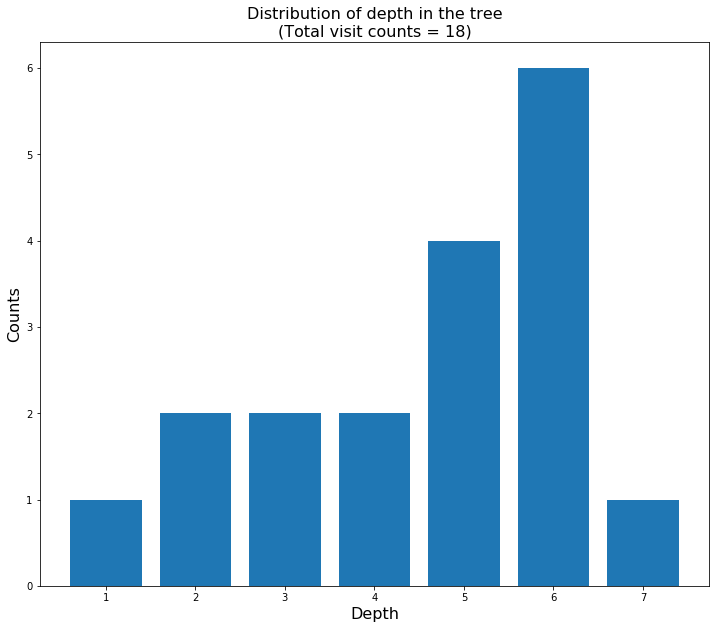

In [95]:
# depths histogram -> do this for different priors and for different total visit counts 
#(they are cached when multiple steps are done)
plt.figure(figsize=(12,10))
plt.hist(depths, bins = np.arange(0, depths.max()+1)+0.5, rwidth=0.8)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Distribution of depth in the tree\n(Total visit counts = %d)"%global_count, fontsize=16)
plt.show()

In [ ]:
# We could even highlight the frames which received most visit counts given a certain depth

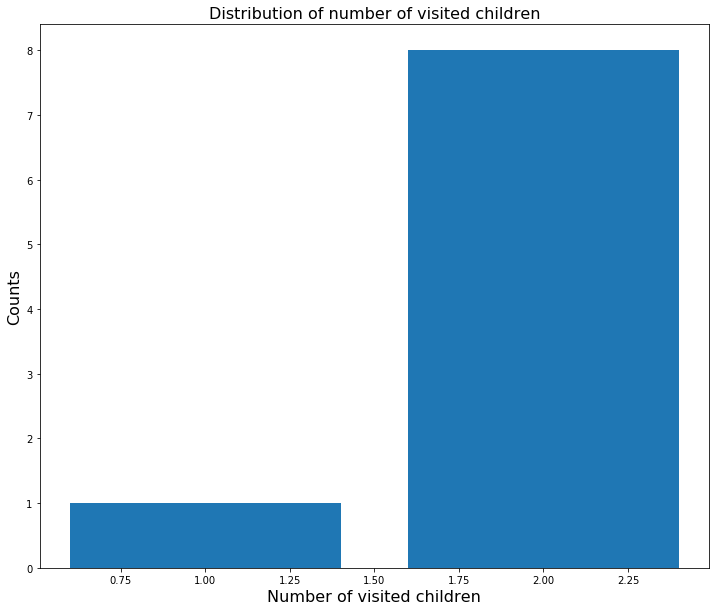

In [96]:
plt.figure(figsize=(12,10))
plt.hist(num_visited_children, bins = np.arange(0, num_visited_children.max()+1)+0.5, rwidth=0.8)
plt.xlabel("Number of visited children", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Distribution of number of visited children", fontsize=16)
plt.show()

In [97]:
def add_jitter(x, eps=0.5e-1):
    s = x.shape
    return x + np.random.rand(s[0])*eps

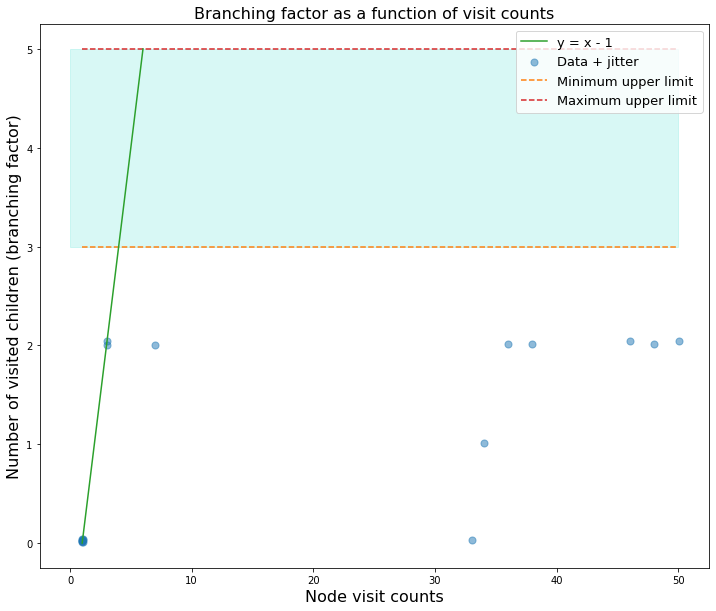

In [98]:
plt.figure(figsize=(12,10))
plt.scatter(add_jitter(visit_counts), add_jitter(num_visited_children), s=50, alpha=0.5, label="Data + jitter")
plt.hlines(3, visit_counts.min(), visit_counts.max(), 
           colors="tab:orange", linestyles="dashed", label="Minimum upper limit")
plt.hlines(5, visit_counts.min(), visit_counts.max(), 
           colors="tab:red", linestyles="dashed", label="Maximum upper limit")
plt.fill_between(np.arange(visit_counts.max()+1), 3, 5, alpha=0.2, color="turquoise")
plt.plot(np.arange(6)+1, np.arange(6), c="tab:green", label="y = x - 1")
plt.xlabel("Node visit counts", fontsize=16)
plt.ylabel("Number of visited children (branching factor)", fontsize=16)
plt.title("Branching factor as a function of visit counts", fontsize=16)
plt.legend(fontsize=13)
plt.show()

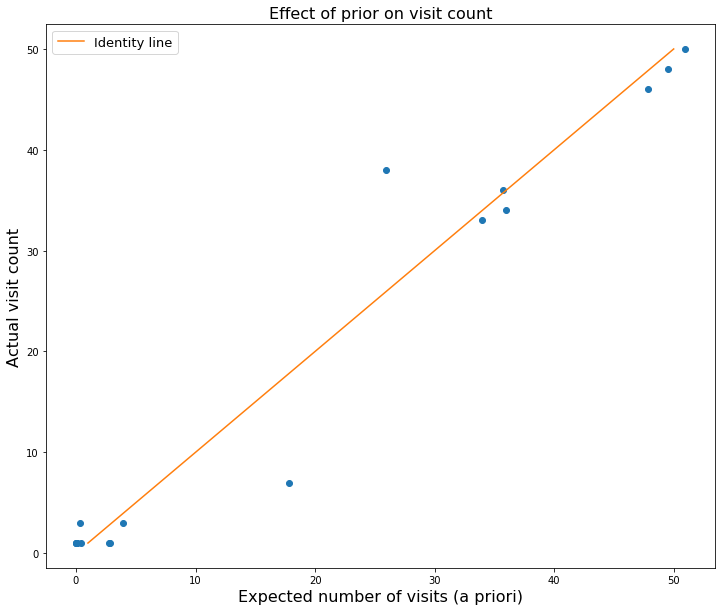

In [129]:
# expected_visit=parent_visit_count*prior, visit_count
expected_visit = parent_visit_counts*priors
plt.figure(figsize=(12,10))
plt.scatter(expected_visit, visit_counts)
plt.plot(np.arange(visit_counts.max())+1, np.arange(visit_counts.max())+1, label ="Identity line", c="tab:orange")
plt.xlabel("Expected number of visits (a priori)", fontsize=16)
plt.ylabel("Actual visit count", fontsize=16)
plt.title("Effect of prior on visit count", fontsize=16)
plt.legend(fontsize=13)
plt.show()

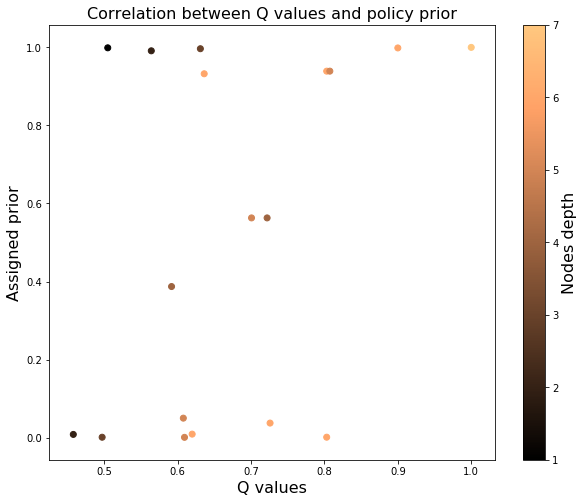

In [127]:
# Q values vs priors -> it also depends on the depth and the discount factor
plt.figure(figsize=(10,8))
plt.scatter(Qvalues, priors, c=depths, cmap="copper")
clb = plt.colorbar()
clb.set_label('Nodes depth',fontdict={"size":16})
plt.xlabel("Q values", fontsize=16)
plt.ylabel("Assigned prior", fontsize=16)
plt.title("Correlation between Q values and policy prior", fontsize=16)
plt.show()